# Predictive Modelling

### Table of Contents TO EDIT
1. [First round of feature selection](#Feature_selection)
2. [Scaling numeric variables](#Scaling)
3. [One-hot encoding](#OHE)
4. [Multicollinearity analysis](#Multicollinearity)
5. [Classification models](#Classification_models)  
    5.1. [Logistic regression](#Logistic_regression)  
    5.2. [Deicision tree](#Decision_tree)  
    5.3. [Random forest](#Random_forest)

## Import dependencies

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import statsmodels
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# A classification problem : the Adult Income dataset

Another common use case in Supervised Learning is classification. Let's try one example now with the **Adult Income** dataset. This dataset was extracted from the 1994 Census database and is described by the following variables:

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- **income**: `>50K`, `<=50K`

Prediction task is to determine whether a person makes over 50K a year.

## Recap of processing data from last week

Recap: (what did to raw data)
* one-hot encoding of variables
* etc

In [81]:
# Upload the data 
df_raw = pd.read_csv("adult.csv", index_col=[0])

# Drop meaningless variables
df_raw = df_raw.drop(['fnlwgt'], axis=1)

# Majority of United-States occurrences HOW TO EXPLAIN THIS??
df_raw = df_raw.drop(['native.country'], axis=1)

# Scale numeric variables  - TODO: perhaps this isn't so important for DT 
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
df_raw.loc[:, numeric_cols] = scaler.fit_transform(df_raw.loc[:, numeric_cols])

# One-hot encode categorical variables 
one_hot_df = pd.get_dummies(df_raw, drop_first=True)


Let's take a look at the new table 

In [82]:
one_hot_df.head()

,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,income_>50K
age,,,,,,,,,,,,,,,,,,,,,
90,-0.420060,-0.14592,10.593507,-0.035429,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82,-0.420060,-0.14592,10.593507,-1.817204,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
66,-0.031360,-0.14592,10.593507,-0.035429,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
54,-2.363558,-0.14592,9.461864,-0.035429,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
41,-0.031360,-0.14592,9.461864,-0.035429,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [83]:
# Build dummy variable for working vs not working ('Without-pay')
for col in one_hot_df.columns:
    if 'workclass_' in col and ' Without-pay' not in col:
        one_hot_df = one_hot_df.drop([col], axis=1)

In [84]:
# Remove education-num as it is difficult to interpret (and we have other columns for education levels)
one_hot_df = one_hot_df.drop(['education.num'], axis=1)

In [85]:
one_hot_df.shape

(32561, 49)

## Multicollinearity analysis <a name="Multicollinearity"></a>

### Variance Inflation Factor

The variance inflation factor measures collinearity between independent variables - it is defined by the following formula: $VIF_{i} = \frac{1}{1 - R_{i}^2}$ for independent variable $X_{i}$, where $R_{i}^2$ is the coefficient of determination of the regression of $X_{i}$ against the other independent variables.

VIF values above 10 indicate that $R_{i}^2$ is above 0.9 and indicates a significant collinearity between variables.

In [43]:
# Remove the target variable from the dataset for the analysis of independent variables
target = one_hot_df['income_>50K']
one_hot_df_indep = one_hot_df.drop('income_>50K', axis=1)

In [45]:
var_names = one_hot_df_indep.columns.tolist()
# Calculate the variance inflation factor for independent variables
vif = [variance_inflation_factor(one_hot_df_indep.values, i) for i in range(len(var_names))]
vif_df = pd.DataFrame(vif, index=range(len(var_names)), columns=['vif']).round(3)
vif_df['feature_name'] = var_names
vif_df.sort_values('vif', ascending=False)

,vif,feature_name
46,61.421,race_White
19,37.029,marital.status_Married-civ-spouse
38,20.349,relationship_Not-in-family
40,12.664,relationship_Own-child
13,11.232,education_HS-grad
41,9.071,relationship_Unmarried
17,8.184,education_Some-college
44,7.766,race_Black
11,6.783,education_Bachelors
47,5.903,sex_Male


In [47]:
# Remove variables with very high VIF values (top 2 in ranking)
one_hot_df_indep = one_hot_df_indep.drop(['race_White'], axis=1)
one_hot_df_indep = one_hot_df_indep.drop(['marital.status_Married-civ-spouse'], axis=1)

In [48]:
# Check VIF values on new table (without variables removed in previous cell)
var_names = one_hot_df_indep.columns.tolist()
vif = [variance_inflation_factor(one_hot_df_indep.values, i) for i in range(len(var_names))]
vif_df = pd.DataFrame(vif, index=range(len(var_names)), columns=['vif']).round(3)
vif_df['feature_name'] = var_names
vif_df.sort_values('vif', ascending=False)

,vif,feature_name
13,6.097,education_HS-grad
45,5.271,sex_Male
17,4.529,education_Some-college
11,4.009,education_Bachelors
20,3.920,marital.status_Never-married
37,3.325,relationship_Not-in-family
32,3.271,occupation_Prof-specialty
39,3.189,relationship_Own-child
26,2.918,occupation_Exec-managerial
25,2.834,occupation_Craft-repair


> How do these values look like, once we have removed the 2 extreme values?

### Correlation matrix

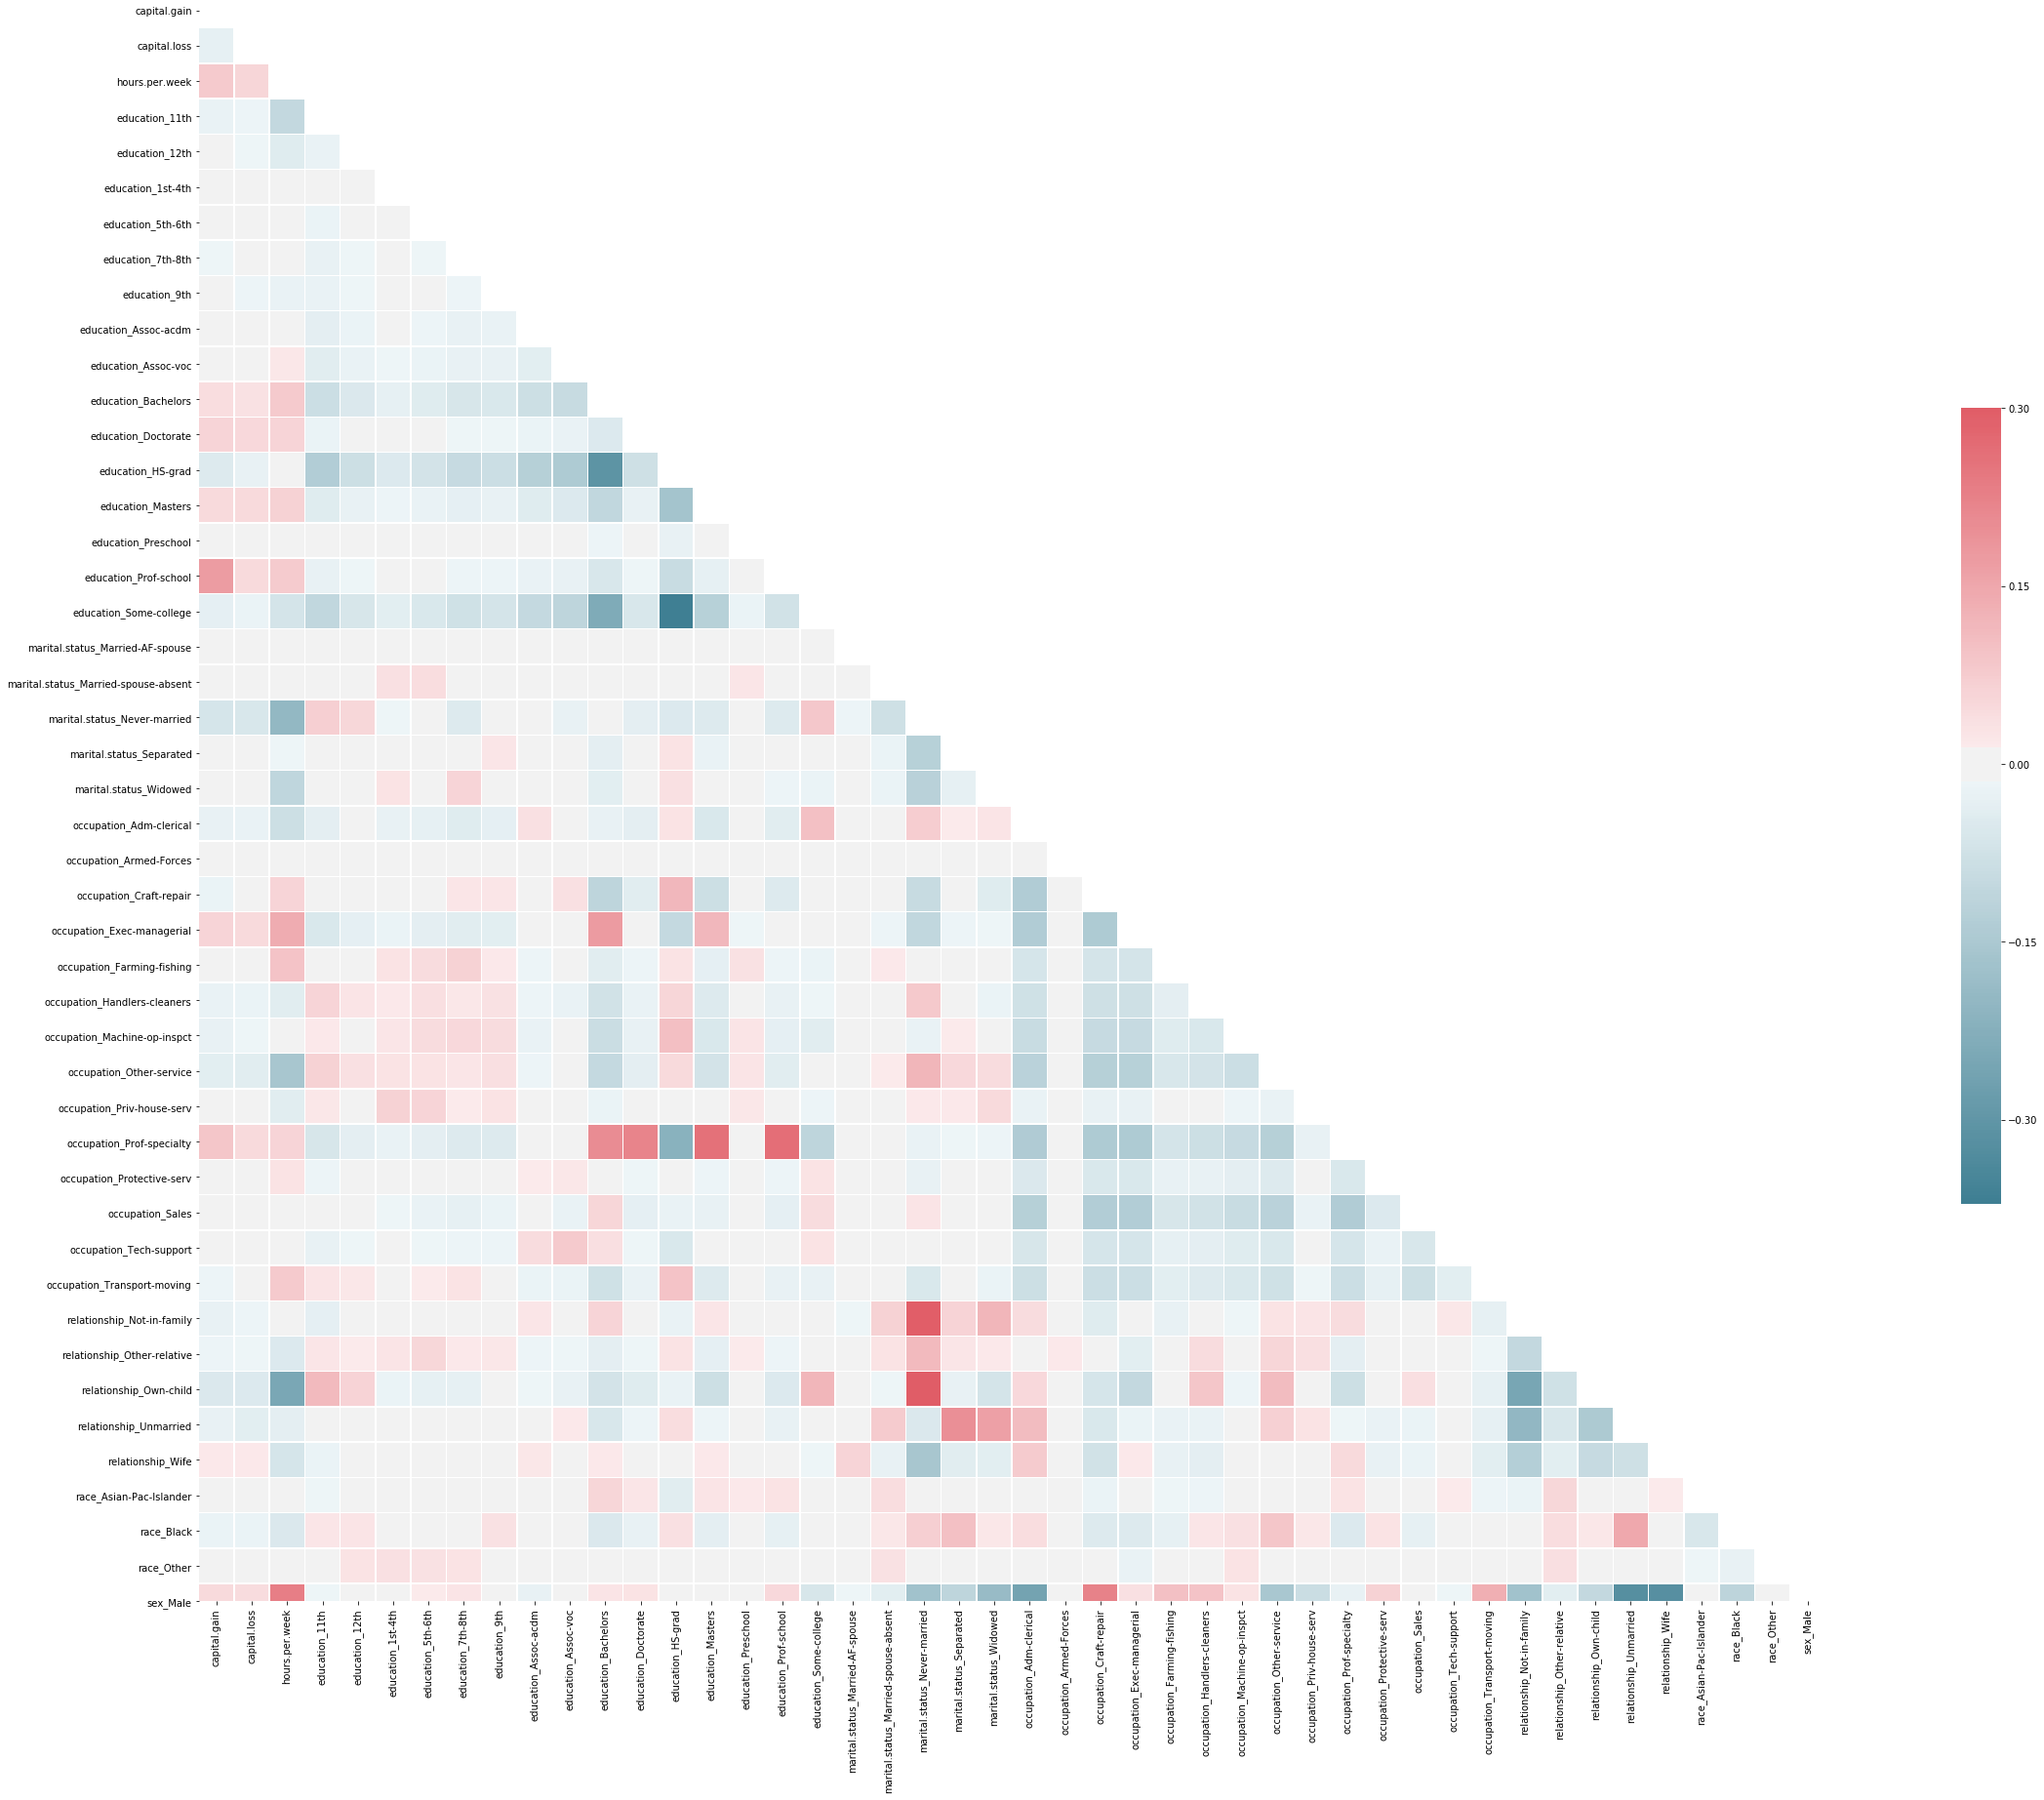

In [49]:
corr = one_hot_df_indep.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the figure and its dimensions
f, ax = plt.subplots(figsize=(50, 30))

# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the correlation matrix with the colormap above
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Predictive modelling <a name="Modelling"></a>

The predictive analysis follows a descriptive stage, once we have:
 - cleaned the data
 - created a few derived variables
 - have a better understanding of the data. 
 
Its aim is to build a performing predictive model and to identify the main explanatory variables. This is an iterative process as a variety of modelling approaches are usually tested and new features are created.

The primary goal of this section is to accurately predict whether an adult is going to make more than 50K a year and understand the drivers explaining such an income.

### Train/test split <a name="Train_test_split"></a>

A good prediction model must be generalisable - i.e., it should be able to make accurate predictions on new data. Several methods exist, to make our model more generalisable, of which the 'train/test split'.

Other methods, such as train/test/validation split and cross-validation take this approach one step further.

In [ ]:
# Splitting the data into training and testing sets - a frequent test set size is 20%-30% of the original dataset

X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2)

### Decision tree <a name="Decision_tree"></a>

A decision tree can be perceived as a set of rules which enable to better describe and predict a given phenomenon, e.g., here, a salary `>50K` or `<= 50K`. As its name indicates, a tree is composed of branches (which link the nodes to one another or to the final leaves), nodes (in the middle of the tree) and leaves (higher end of the tree).

In our case, the tree splits at each node, on a **rule/condition** (explanatory variable and a set of values - e.g., **age > 38**) according to a criterion (Gini), to better separate `>50K` vs `<= 50K` populations.

The decision tree algorithm has several important hyperparameters (cf. below). Understanding these will enable you to avoir overfitting:

* the splitting criterion, for each node: Gini (most frequently used), entropy etc.
* the maximum depth of the tree: how many branches link the first node to the end leaves?
* the minimum sample split: the minimum number of data points in each node, after a split
* the minimum samples per leaf: the minimum number of data points in each final leaf
* the maximum number of features to consider when looking for the best split *(from the sklearn documentation)*:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.

In [ ]:
# Decision tree
# Initiate your Decision Tree Classifier model
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)

# Fit your Decision Tree model to your train model
clf.fit(X_train, y_train)

# Predict labels on your Test set of independent variables
pred_clf = clf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_clf = clf.predict_proba(X_test)

### Feature importance

In [ ]:
# Plot feature importance
features_log = pd.DataFrame(clf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'blue')
plt.xlabel('Feature importance')
plt.title('Feature importance for the logistic regression model')
plt.show()

## Advanced (aka I'm feeling smart)

### Random Forest <a name="Random_forest"></a>

In the previous section, we tested models with various parameters manually. There exists *smarter* ways of selecting a model's hyperparameters, as grid search. Let's test this approach and see which hyperparameters are selected.

#### Boosting vs bagging

* In this section, we are going to explore new types of models (random forests and XGBoost), which are globally called 'ensemble methods'. 

* The idea behind ensemble methods is to combine several models to have a better predictive performance. E.g., a single decision tree, is a weak model. If we build several decision trees on samples of the data, the final model will be more robust to outliers and will hence have a better predictive performance. 

* To understand this concept, we need to have a look at bagging and boosting, which are two sampling methods used in ensemble methods.

* **Bagging** consists in sampling with replacement. Ensemble methods using the bagging approach, build models on each sample of data; the final score of the ensemble model will be a *vote* for classification and an average for regression.

* In **Boosting**, data points all have equal weights at the beginning. These weights are increased, if the data points are misclassified (the algorithm will focus on them) and decreased, if they are well classified. 

In [ ]:
'''
Let's try to tune the hyperparameters of a random forest, in order to classify adult populations 
based on their income. A Random forest consists in an ensemble of bagged decision trees 
(built on subsets of the data, which are sampled with replacement). 
Tree nodes are split on a random subset of features. The amount of features selected is 
one of the hyperparameters of the model (max_features, here).

NB: In general, a smaller subset of variables produces less correlation and as such, a lower error rate.
There a few rules of thumb:

If M is the number of features in the dataset and m is the max number of features randomly sampled:

m << M

- for regression: m = M/3
- for classification: m = sqrt(M)
'''

Markdown = (""" Common pitfall: Random forest and boosted trees are not the same!""")

# Initiate the Random Forest Classifier object
clf_rf = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, min_samples_leaf=30, max_features=4)

In [ ]:
# Fit your Random Forest to your train data
clf_rf.fit(X_train, y_train)

In [ ]:
# Predict labels on your Test set of independent variables
pred_rf = clf_rf.predict(X_test)
# Predict probabilities on your Test set of independent variables
proba_rf = clf_rf.predict_proba(X_test)